In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# use the keras.utils.get_file method to download the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    fname="flower_photos",
    origin=dataset_url,
    untar=True,
    cache_dir="."
)

In [4]:
import pathlib

In [5]:
# convert to Path object
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

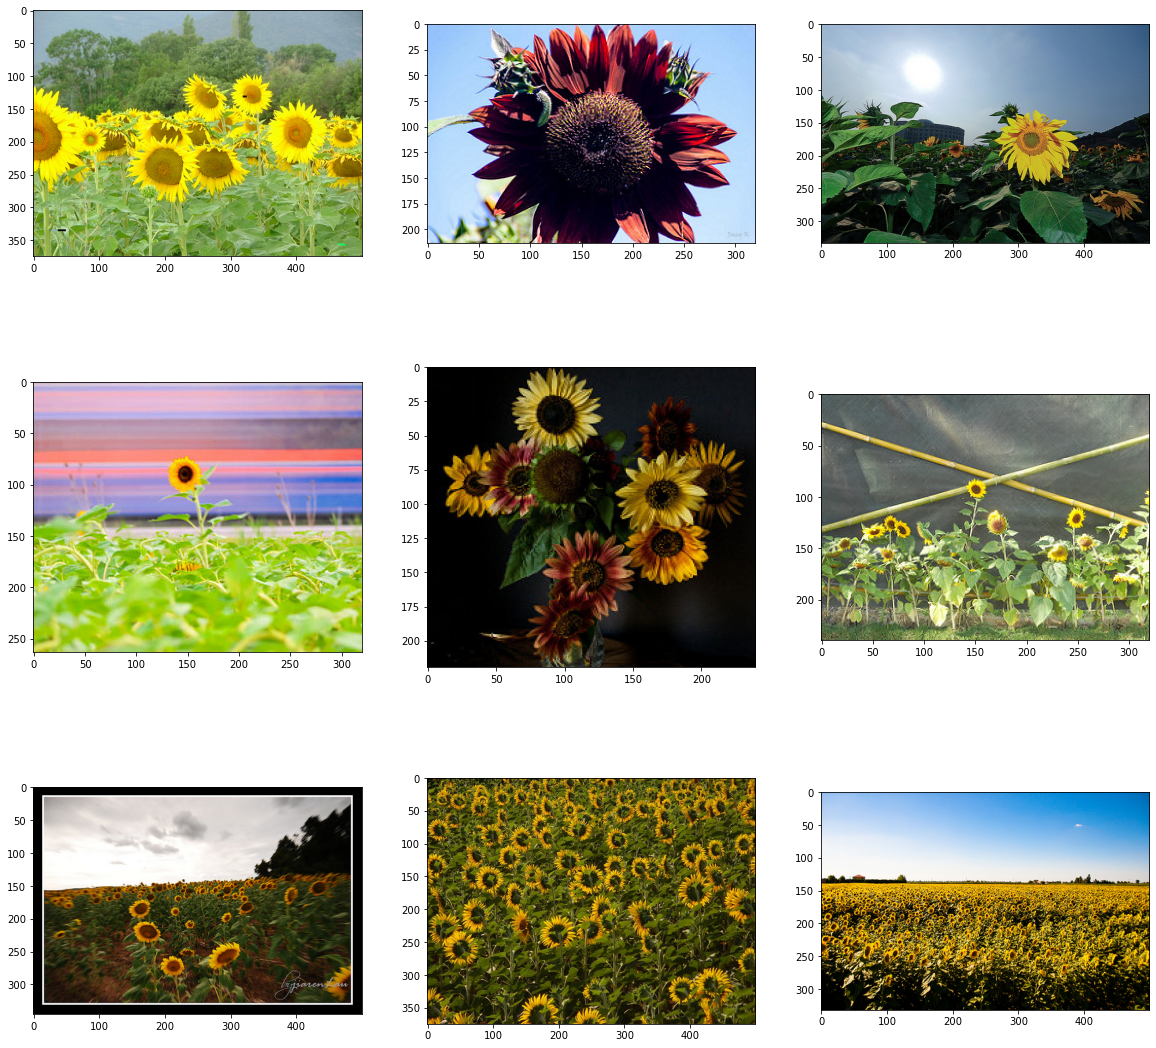

In [6]:
# plot roses
roses = list(data_dir.glob("sunflowers/*.jpg"))
roses_count = len(roses)
plot_count = 9
random_indices = [np.random.randint(0,roses_count) for count in range(plot_count)]

plt.figure(figsize=(20,20))
for images in range(plot_count):
    plt.subplot(3,3,images+1)
    plt.imshow(cv2.imread(str(roses[random_indices[images]]))[:,:,::-1])

Training set  = 80%; Validation set = 10%; Testing set = 10%

In [7]:
# load images off disk using keras.utils.image_dataset_from_directory
# set parameters
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
# validation and testing set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [27]:
# create separate validation and testing datasets
val_test_size = len(val_test_ds)
val_test_ds = val_test_ds.shuffle(50)
val_ds = val_test_ds.take(int(0.5*val_test_size))
test_ds = val_test_ds.skip(int(0.5*val_test_size))

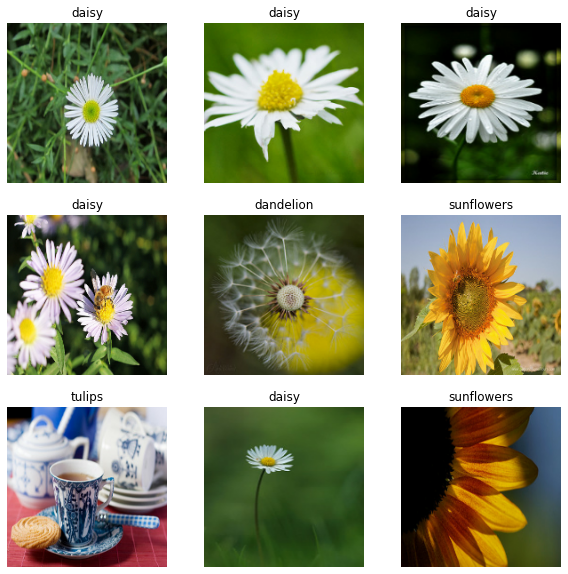

In [40]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
# train without augmentation
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [42]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [44]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
92/92 [==============================] - 52s 566ms/step - loss: 0.6191 - accuracy: 0.7691 - val_loss: 1.1499 - val_accuracy: 0.6165
Epoch 2/15
92/92 [==============================] - 53s 570ms/step - loss: 0.4246 - accuracy: 0.8471 - val_loss: 1.1598 - val_accuracy: 0.6457
Epoch 3/15
92/92 [==============================] - 53s 573ms/step - loss: 0.2688 - accuracy: 0.9101 - val_loss: 1.5012 - val_accuracy: 0.5771
Epoch 4/15
92/92 [==============================] - 54s 582ms/step - loss: 0.1604 - accuracy: 0.9469 - val_loss: 1.4906 - val_accuracy: 0.6171
Epoch 5/15
92/92 [==============================] - 53s 580ms/step - loss: 0.1132 - accuracy: 0.9659 - val_loss: 1.7809 - val_accuracy: 0.6136
Epoch 6/15
92/92 [==============================] - 55s 592ms/step - loss: 0.0792 - accuracy: 0.9802 - val_loss: 1.8050 - val_accuracy: 0.6371
Epoch 7/15
92/92 [==============================] - 54s 585ms/step - loss: 0.0572 - accuracy: 0.9826 - val_loss: 2.1200 - val_accuracy: 0.6029